## Performance test

In [19]:
import tracemalloc
 
# code or function for which memory
# has to be monitored
def app():
    lt = []
    for i in range(0, 1000000):
        lt.append(i)
 
# starting the monitoring
tracemalloc.start()
 
# function call
app()
 
# displaying the memory
print(tracemalloc.get_traced_memory()[1]/1024/1024)
 
# stopping the library
tracemalloc.stop()

34.754262924194336


In [20]:
from SVD_test import *
import tracemalloc
import time

REF = 'ref'
READ = 'read'
INDEX = '01'
REF += '_'+INDEX+'.txt'
READ += '_'+INDEX+'.txt'

tracemalloc.start()
start_time = time.time()

with open(REF) as f:
    ref = f.read().splitlines()[0]
with open(READ) as f:
    reads = f.read().splitlines()

data_list, normal_space = get_reads_maping_data(reads, ref)
type_count, breakpoint = get_type_count(data_list, normal_space, ref)
print(get_SV(type_count, breakpoint, ref))

print('Execute time: {} s'.format(time.time()-start_time))
current, peak = tracemalloc.get_traced_memory()
print('Current: {} MB, Peak: {} MB'.format(current/1024/1024, peak/1024/1024))
tracemalloc.stop()


FileNotFoundError: [Errno 2] No such file or directory: 'ref_01.txt'

## Settings

In [1]:
import numpy as np
import os
import time
from SVD_test import get_SV
from variance_type import VarianceType
from testcase_generator import generate_testcase
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
RESULT_FOLDER = "result/"
REF_RANGE = range(500, 2000, 100)
READ_PERCENT_RANGE = np.arange(3, 8, 0.5)
REPEAT = 5
# How much index error is acceptable
# For example, real=138 and ACCEPTABLE_MISPLACE=1, so 137,139 are count as correct
ACCEPTABLE_MISPLACE = 3


## Generate test cases

In [15]:
for var_type in VarianceType:
    df = pd.DataFrame([], columns=["real_type", "real_start", "real_end", "read_count", "var_size"])
    folder_path = "testcase/" + var_type.name + "/"

    for ref_len in REF_RANGE:
        for read_len_percent in READ_PERCENT_RANGE:
            read_len_percent = int(read_len_percent * 10)
            read_len = read_len_percent * ref_len // 1000

            for i in range(REPEAT):
                index = "{}_{}_{}".format(ref_len, read_len_percent, i)
                print(
                    "Generating {} Ref: {}, Read: {}% ({}), Repeat: {}       ".format(
                        var_type.name, ref_len, read_len_percent / 10, read_len, i
                    ),
                    end="\r",
                )
                read_dist = random.randint(read_len // 2, read_len + read_len // 2)

                if var_type == VarianceType.INSERTION_BIGGER:
                    var_size = random.randint(read_len // 2, read_len - 1)
                else:
                    var_size = random.randint(read_len, ref_len // 3)

                var_padding = read_dist + read_len * 2
                shift_min = random.randint(read_len // 8, read_len // 4)
                shift_max = random.randint(read_len // 4, read_len // 2)

                type, start, end, read_count = generate_testcase(
                    "testcase/" + var_type.name + "/",
                    index,
                    var_type.value,
                    read_len,
                    read_dist,
                    ref_len,
                    var_size,
                    var_padding,
                    shift_min,
                    shift_max,
                )
                df.loc[index] = [type.name, start, end, read_count, var_size]

    df.to_csv(RESULT_FOLDER + "real_{}.csv".format(var_type.name))
    print("Generating {} finished                                     ".format(var_type.name))


Generating DELETION finished                                     
Generating INSERTION_BIGGER finished                                     
Generating INSERTION_SMALLER finished                                     
Generating TANDEM finished                                     
Generating INVERSION finished                                     
Generating TRANSLOCATION finished                                     


## Predict

In [25]:
for var_type in VarianceType:
    if (var_type == VarianceType.DELETION):
        continue
    folder_path = "testcase/" + var_type.name + "/"
    df = pd.DataFrame([], columns=["type", "start", "end", "time(s)"])
    real = pd.read_csv(RESULT_FOLDER + "real_{}.csv".format(var_type.name), index_col=0)

    for ref_len in REF_RANGE:
        for read_len_percent in READ_PERCENT_RANGE:
            read_len_percent = int(read_len_percent * 10)

            for i in range(REPEAT):
                index = "{}_{}_{}".format(ref_len, read_len_percent, i)
                start_time = time.time()

                ref_path = folder_path + "ref_{}.txt".format(index)
                read_path = folder_path + "read_{}.txt".format(index)
                read_len = read_len_percent * ref_len // 1000
                print(
                    "Predicting {} Ref: {}, Read: {}% ({}), Round: {}          ".format(
                        var_type.name, ref_len, read_len_percent / 10, read_len, i
                    ),
                    end="\r",
                )
                with open(ref_path) as f:
                    ref = f.read().splitlines()[0]
                with open(read_path) as f:
                    reads = f.read().splitlines()
                type, start, end = get_SV(reads, ref)

                cpu_time = time.time() - start_time

                df.loc[index] = [type.name, start, end, cpu_time]

    df.to_csv(RESULT_FOLDER + "predict_{}.csv".format(var_type.name))

    summary = pd.concat([real, df], axis=1)
    summary.to_csv(RESULT_FOLDER + "summary_{}.csv".format(var_type.name))

    print("Predicting {} finished                                     ".format(var_type.name))


Predicting INSERTION_BIGGER finished                                       
Predicting INSERTION_SMALLER finished                                       
Predicting TANDEM finished                                       
Predicting INVERSION finished                                       
Predicting TRANSLOCATION finished                                       


## Analyze result

---------- DELETION ----------
Accuracy: 68.62222222222215 %


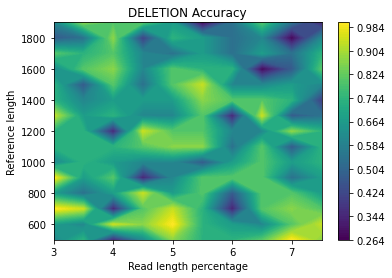

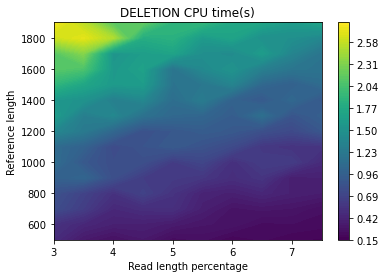

---------- INSERTION_BIGGER ----------
Accuracy: 70.1333333333333 %


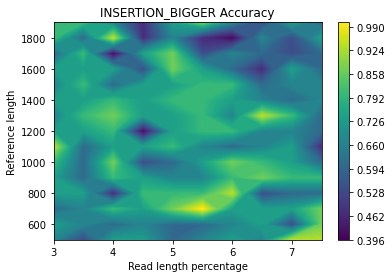

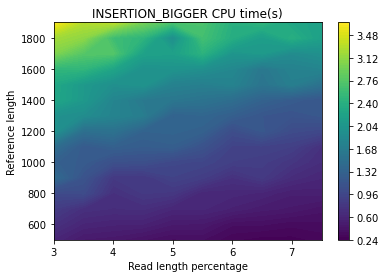

---------- INSERTION_SMALLER ----------
Accuracy: 66.08888888888889 %


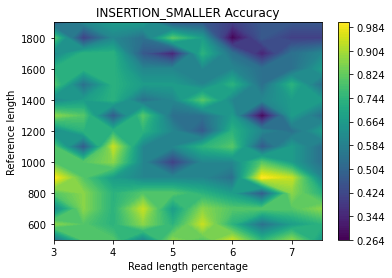

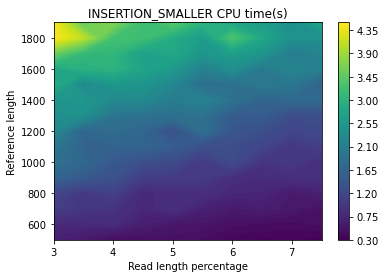

---------- TANDEM ----------
Accuracy: 62.57777777777774 %


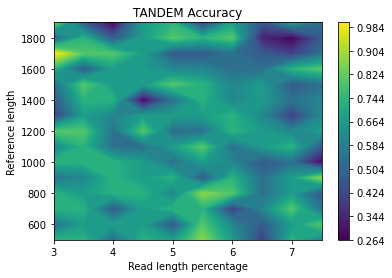

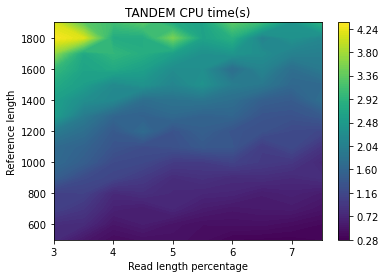

---------- INVERSION ----------
Accuracy: 54.755555555555546 %


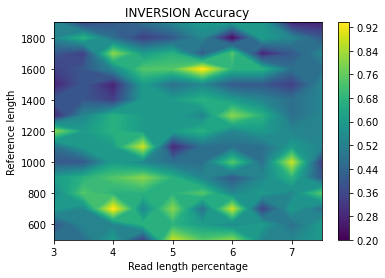

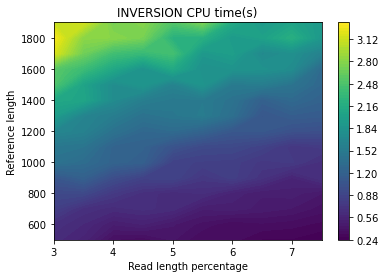

---------- TRANSLOCATION ----------
Accuracy: 77.06666666666666 %


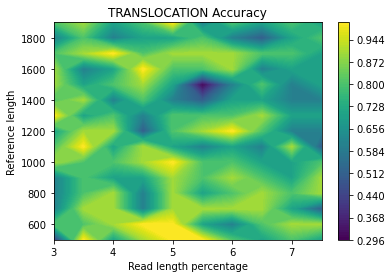

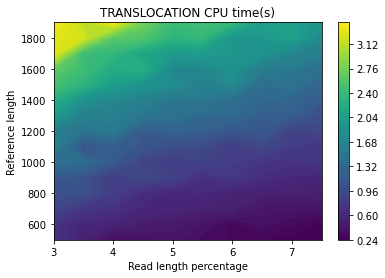

In [18]:
# Scoring methods
# Max 3 points
# 1. type match
# 2. start match
# 3. end match (except for translocation)

for var_type in VarianceType:
    folder_path = "testcase/" + var_type.name + "/"
    acc_df = pd.DataFrame(index=REF_RANGE, columns=READ_PERCENT_RANGE)
    time_df = pd.DataFrame(index=REF_RANGE, columns=READ_PERCENT_RANGE)
    summary = pd.read_csv(RESULT_FOLDER + "summary_{}.csv".format(var_type.name), index_col=0)

    if var_type == VarianceType.TRANSLOCATION:
        MAX_POINT = 2
    else:
        MAX_POINT = 3

    for ref_len in REF_RANGE:
        for read_len_percent in READ_PERCENT_RANGE:
            point = 0
            cpu_time = 0
            for i in range(REPEAT):
                index = "{}_{}_{}".format(ref_len, int(read_len_percent * 10), i)
                data = summary.loc[index]
                cpu_time += data['time(s)']
                if data["real_type"] == data["type"]:
                    point += 1
                if (
                    data["real_start"] - ACCEPTABLE_MISPLACE <= data["start"]
                    and data["real_start"] + ACCEPTABLE_MISPLACE >= data["start"]
                ):
                    point += 1
                if (
                    data["real_end"] - ACCEPTABLE_MISPLACE <= data["end"]
                    and data["real_end"] + ACCEPTABLE_MISPLACE >= data["end"] and var_type != VarianceType.TRANSLOCATION
                ):
                    point += 1
            
            accuracy = point / (MAX_POINT * REPEAT)
            acc_df.at[ref_len, read_len_percent] = accuracy

            mean_cpu_time = cpu_time / REPEAT
            time_df.at[ref_len, read_len_percent] = mean_cpu_time
    acc_df.to_csv(RESULT_FOLDER + "accuracy_{}.csv".format(var_type.name))
    print("---------- {} ----------".format(var_type.name))
    
    X = acc_df.columns.values
    Y = acc_df.index.values
    Z = acc_df.values
    print('Accuracy: {} %'.format(Z.mean()*100))
    plt.contourf(X, Y, Z, 100)
    plt.title('{} Accuracy'.format(var_type.name))
    plt.xlabel('Read length percentage')
    plt.ylabel('Reference length')
    plt.colorbar()
    plt.show()

    X = time_df.columns.values
    Y = time_df.index.values
    Z = time_df.values
    plt.contourf(X, Y, Z, 100)
    plt.title('{} CPU time(s)'.format(var_type.name))
    plt.xlabel('Read length percentage')
    plt.ylabel('Reference length')
    plt.colorbar()
    plt.show()

